### Analisi Tweet in inglese per Hate Speech Detection

In [1]:
# Luigi Saetta
# Dicembre 2019
# l'analisi utilizza una CONv1D ed una Bidirectional GRU

# il dataset con i tweet è preso dal sito: 
# https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data
# e scaricato in una directory locale

In [2]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# per affrontare un problema di duplicate library che produce crash del kernel jupyter
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
FNAME = "./hatespeech/english_labeled_data.csv"

data = pd.read_csv(FNAME)

In [4]:
# rimuove i caratteri di punteggiatura, le cifre, spazi duplicati, newline, leading blank
def remove_chars(str):
    s = re.sub(r'[^\w\s]',' ',str)
    # remove digits
    s = ''.join([i for i in s if not i.isdigit()])
    # replace multiple blank with one
    s = re.sub('\s+', ' ', s).strip()
    # remove leading blank
    s = s.lstrip()
    # remove eventual newline
    s = s.replace("\n","")
    # trasforma tutto in minuscolo
    s = s.lower()
    return s

In [5]:
# testiamo la funzione remove_chars

str1 = " @Carattere  Blank  iniziale  la123hello"
str2 = "@carattere blank iniziale la"

print(remove_chars(str1))
print(remove_chars(str2))

carattere blank iniziale lahello
carattere blank iniziale la


In [6]:
# data preprocessing

In [7]:
# aggiungo la colonna label e la inizializzo
data['label'] = 0

data.loc[data['class'] == 0, 'label'] = 1
data.loc[data['class'] == 1, 'label'] = 1
# non necessaria: data.loc[data['class'] == 2, 'label'] = 0

In [8]:
# elimino punteggiatura dai tweet applicando remove_chars
data['tweet'] = data['tweet'].apply(remove_chars)

In [9]:
data

,id,count,hate_speech,offensive_language,neither,class,tweet,label
0,0,3,0,0,3,2,rt mayasolovely as a woman you shouldn t compl...,0
1,1,3,0,3,0,1,rt mleew boy dats cold tyga dwn bad for cuffin...,1
2,2,3,0,3,0,1,rt urkindofbrand dawg rt sbabylife you ever fu...,1
3,3,3,0,2,1,1,rt c_g_anderson viva_based she look like a tranny,1
4,4,6,0,6,0,1,rt shenikaroberts the shit you hear about me m...,1
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you s a muthaf in lie lifeasking _pearls corey...,1
24779,25292,3,0,1,2,2,you ve gone and broke the wrong heart baby and...,0
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...,1
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,1


In [10]:
# shuffle the dataframe before split in train, test
data = data.sample(frac=1)

# split in train, test (circa (80,20))
test = data[1:5000]
train = data[5000:]

In [11]:
train_sentences = train['tweet']
train_labels = train['label']
test_sentences = test['tweet']
test_labels = test['label']

# converto in liste
train_sentences = train_sentences.tolist()
test_sentences = test_sentences.tolist()

# devo trasformare in numpy array
train_labels_final = np.array(train_labels)
test_labels_final = np.array(test_labels)

In [12]:
# step 1. costruisco la embedding index dal file salvato (vedi riga commentata)
# il file è stato spostato nella directory italian

embeddings_index = {}
f = open(os.path.join(".", 'english/glove.6B.100d.txt'))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
# iper-parameters
NUM_WORDS=25000 # word index ne contiene solo 30000
# dipende dall'emebeddings GloVE scelto
EMBEDDING_DIM=100
# attenzione: è la lunghezza delle sequenze, non il numero di caratteri (ho ridotto a 100)
MAX_LEN=100

In [14]:
# verifica le max len prima del padding (e truncate)
# calcola la maxlen in termini di parole
train_max_words = 0
test_max_words = 0

for s in train_sentences:
    l = len(s.split())
    if l > train_max_words:
        train_max_words = l

print(train_max_words)

for s in test_sentences:
    l = len(s.split())
    if l > test_max_words:
        test_max_words = l

print(test_max_words)

34
33


In [15]:
# ho specificato un Out of Vocabulary Token.
# nel trasformare le frasi in sequenze di numeri, tutte le parole OOV saranno codificate come il oov_token
# in questo modo si può tenere traccia delle OOV e non perderle semplicemente nella codifica
tokenizer = Tokenizer(num_words = NUM_WORDS, oov_token = "<oov>")

In [16]:
tokenizer.fit_on_texts(train_sentences)

In [17]:
# questo è il dizionario che codifica
word_index = tokenizer.word_index
print(word_index)

{'<oov>': 1, 'i': 2, 'a': 3, 'bitch': 4, 'rt': 5, 'the': 6, 't': 7, 'you': 8, 'to': 9, 'and': 10, 'that': 11, 'my': 12, 'in': 13, 'bitches': 14, 'co': 15, 'is': 16, 'http': 17, 'like': 18, 'me': 19, 's': 20, 'it': 21, 'of': 22, 'on': 23, 'be': 24, 'hoes': 25, 'this': 26, 'for': 27, 'pussy': 28, 'hoe': 29, 'all': 30, 'with': 31, 'm': 32, 'ass': 33, 'your': 34, 'if': 35, 'they': 36, 'but': 37, 'up': 38, 'don': 39, 'just': 40, 'get': 41, 'so': 42, 'fuck': 43, 'can': 44, 'no': 45, 'she': 46, 'when': 47, 'shit': 48, 'these': 49, 'u': 50, 'got': 51, 'not': 52, 'nigga': 53, 'was': 54, 'trash': 55, 'are': 56, 'her': 57, 'he': 58, 'out': 59, 'lol': 60, 'at': 61, 'have': 62, 'what': 63, 'amp': 64, 'ain': 65, 'about': 66, 'some': 67, 'we': 68, 'know': 69, 'do': 70, 'niggas': 71, 'who': 72, 'how': 73, 'love': 74, 'one': 75, 're': 76, 'them': 77, 'or': 78, 'as': 79, 'go': 80, 'fucking': 81, 'now': 82, 'yo': 83, 'want': 84, 'why': 85, 'from': 86, 'bad': 87, 'then': 88, 'man': 89, 'good': 90, 'too': 

In [18]:
# sequenza di interi per codificare tweet di TRAIN
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences_padded = pad_sequences(train_sequences, maxlen = MAX_LEN)
# TEST
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences_padded = pad_sequences(test_sequences, maxlen = MAX_LEN)

In [19]:
# prepara la matrice dei word embeddings
# considera solo i word embeddings per le NUM_WORDS selezionate come parte del dizionario

embedding_matrix = np.zeros((NUM_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(25000, 100)

In [21]:
# let's try with a *** BIDIRECTIONAL GRU ***

In [23]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
# costruisco il modello Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint


# per riproducibilità (un qualsiasi seed va bene)
np.random.seed(42)
tf.random.set_seed(42)

model2 = Sequential()
model2.add(Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
model2.add(Conv1D(128, 3, activation='relu'))
model2.add(MaxPooling1D(3))
model2.add(Bidirectional(GRU(32, dropout = 0.25, recurrent_dropout = 0.25)))
model2.add(Dense(1, activation='sigmoid'))

In [24]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,569,697
Trainable params: 69,697
Non-trainable params: 2,500,000
_________________________________________________________________


In [26]:
# checkpoint per salvare best model
filepath="weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [27]:
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [28]:
history = model2.fit(train_sequences_padded, train_labels_final, validation_split=0.2, batch_size=1024, epochs=10, 
                    shuffle=False, callbacks=callbacks_list)

Train on 15826 samples, validate on 3957 samples
Epoch 1/10
15360/15826 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.7713
Epoch 00001: val_accuracy improved from -inf to 0.83017, saving model to weights-01-0.83.hdf5
15826/15826 [==============================] - 29s 2ms/sample - loss: 0.5342 - accuracy: 0.7730 - val_loss: 0.4345 - val_accuracy: 0.8302
Epoch 2/10
15360/15826 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8316
Epoch 00002: val_accuracy did not improve from 0.83017
15826/15826 [==============================] - 22s 1ms/sample - loss: 0.4290 - accuracy: 0.8315 - val_loss: 0.4076 - val_accuracy: 0.8302
Epoch 3/10
15360/15826 [============================>.] - ETA: 0s - loss: 0.4013 - accuracy: 0.8338
Epoch 00003: val_accuracy improved from 0.83017 to 0.84054, saving model to weights-03-0.84.hdf5
15826/15826 [==============================] - 22s 1ms/sample - loss: 0.4009 - accuracy: 0.8340 - val_loss: 0.3835 - val_accuracy

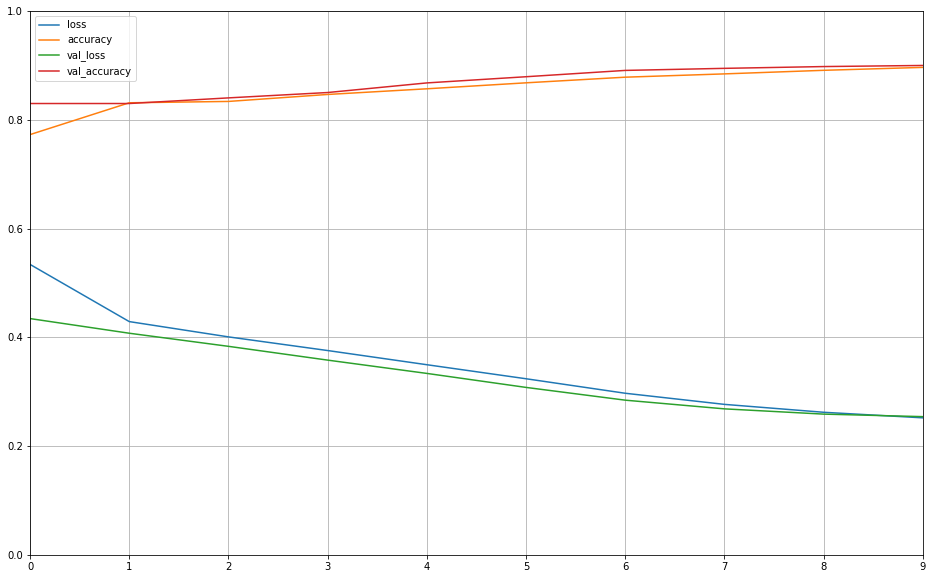

In [29]:
# fa il plot delle curce delle metriche di accuratezza
pd.DataFrame(history.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [30]:
# carico il best model e valuto accuracy sul test set
# devo inserire il nome del file relativo al best model
FILE_BEST = "weights-10-0.90.hdf5"

model2.load_weights(FILE_BEST)
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [31]:
model2.evaluate(x=test_sequences_padded, y=test_labels_final)

4999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.24626962657832316, 0.890178]

In [ ]:
# con Bidirectional GRU si ottiene il 90.5% di accuracy
# con BIdi LSTM 90.6

In [32]:
# sul test set l'accuratezza è 90% Buona !!!
label_pred_test = model2.predict(test_sequences_padded)

label_pred_test = (label_pred_test > 0.5)

In [33]:
cm_test = confusion_matrix(test_labels_final, label_pred_test)

# la confusion matrix (calcolata su TEST)
cm_test

array([[ 424,  385],
       [ 164, 4026]])

In [34]:
# dal punto di vista dell'accuratezza, il problema maggiore è un numero eccessivo di falsi positivi (307) 
# con LSTM 294

In [35]:
# calcolo precision e recall
tn, fp, fn, tp = cm_test.ravel()

In [36]:
precision = tp / (tp + fp)
round(precision, 3)

0.913

In [37]:
recall = tp/(tp + fn)
round(recall, 3)

0.961